In [1]:
import sys
sys.path.insert(1,'../')
import EOBRun_module

import time
import pycbc
import pycbc.noise
import pylab
import lal
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from pycbc import psd, filter
from matplotlib import rc
import gwpy
from gwpy.frequencyseries import FrequencySeries
from pycbc import types
#plt.rcParams['font.family'] = 'DejaVu Sans'
#rc('text', usetex=True)
plt.rcParams.update({'font.size': 16.5})

from multiprocessing import Pool
import h5py
import pandas as pd
import json
import os
import csv
from scipy.interpolate import interp1d
from scipy.fft import fft, ifft
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [2]:
import matplotlib.pyplot as pp
import numpy as np
import sxs

#extrapolation_order = 4
extrapolation_order = 2
#simulation_file = sxs.load("SXS:BBH:1355/Lev5/rhOverM", extrapolation_order=extrapolation_order)
w_metafile = sxs.load("SXS:BBH:1355/Lev5/metadata.json")

simulation_file = '/Users/kailaiwang/.sxs/cache/SXS:BBH:1355v2/Lev5/rhOverM_Asymptotic_GeometricUnits_CoM.h5'
simulation_metafile = '/Users/kailaiwang/.sxs/cache/SXS:BBH:1355v5/Lev5/metadata.json'


Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer
Found the following files to load from the SXS catalog:
    SXS:BBH:1355v5/Lev5/metadata.json


In [3]:
w_metafile

Metadata([('simulation_name', 'empe_002/Lev5'),
          ('alternative_names', 'SXS:BBH:1355'),
          ('initial_data_type', 'BBH_SKS'),
          ('object_types', 'BHBH'),
          ('number_of_orbits', 13.9022669312),
          ('reference_mass_ratio', 0.9999999628583027),
          ('reference_chi_eff', -1.6384006142397264e-05),
          ('reference_chi1_perp', 2.4178425135734773e-08),
          ('reference_chi2_perp', 2.4517759053070228e-08),
          ('reference_eccentricity', 0.067823),
          ('reference_dimensionless_spin1',
           [2.13210141632e-08, -1.14022243957e-08, -1.63733813807e-05]),
          ('reference_dimensionless_spin2',
           [-2.18996211439e-08, 1.10239274071e-08, -1.63946309037e-05]),
          ('reference_orbital_frequency',
           [-2.76221679549e-12, 2.48816213747e-13, 0.0162925781437]),
          ('reference_mass1', 0.500004055942),
          ('reference_mass2', 0.500004074513),
          ('reference_time', 320.0),
          ('referen

In [4]:
# load metadata
mass=100
metadata = {}
with open(simulation_metafile) as file:
    metadata = simulation_metafile
    
# af = metadata['remnant_dimensionless_spin'][-1]
# mf = metadata['remnant_mass']
# mass1 = metadata['reference_mass1']*mass
# mass2 = metadata['reference_mass2']*mass
# spin1 = metadata['reference_dimensionless_spin1'][-1]
# spin2 = metadata['reference_dimensionless_spin2'][-1]

af = 0.686053505285
mf = 0.951500091142
mass1 = 0.500004055942*mass
mass2 = 0.500004074513*mass
spin1 = -1.63733813807e-05
spin2 = -1.63946309037e-05


# Define the physical parameters
massratio = mass1/mass2;
distance = 400; 
inclination = 0; l=2; m=2; 

In [5]:
# load the data
gw_nr = {}
gw_nr = h5py.File(simulation_file, 'r') 
#gw_nr = simulation_file
gw_nr = gw_nr["Extrapolated_N3.dir"]["Y_l2_m2.dat"] 
times = gw_nr[:,0]
hp=gw_nr[:,1]
hc=gw_nr[:,2]
h=hp +1j*hc

In [6]:
# resample to uniform step and flip to positive frequencies
dt=0.5
h_int=interp1d(times, h, kind='cubic')
times_int= np.arange(times[0], times[-1], dt)
h=h_int(times_int)
tmrg = times_int[np.argmax(np.abs(h))]
print('tmrg = {}'.format(tmrg))
times_int = times_int - tmrg # shift to mrg
hp=h.real
hc=h.imag

h=hp -1j*hc
hm=((-1)**l)*(np.conj(h))

tmrg = 3262.976151652388


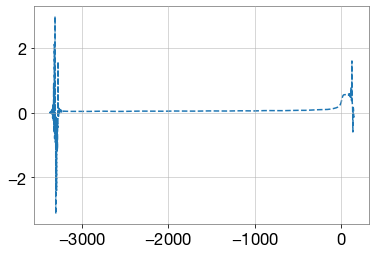

In [7]:
#compute the frequency
sxsphas = np.angle(h)
sxsphas = np.unwrap(sxsphas)
sxsfreq = np.gradient(sxsphas, times_int)
sxsfreq_int = interp1d(times_int,sxsfreq,kind='cubic')
plt.plot(times_int, sxsfreq, '--', label=r'$\Re{(Rh_{22}/(M\nu))}$')

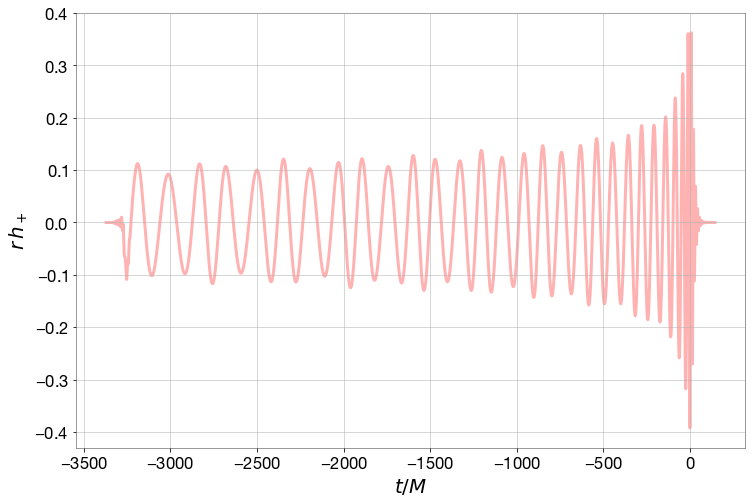

In [8]:
# plot the nr data
plt.figure(figsize = (12, 8))
plt.plot(times_int, hp, "r", alpha=0.3, lw=3, label=r'$Lev6$: real')
#plt.plot(times_int, np.sqrt(hp**2+hc**2), "r", alpha=0.3, lw=3, label=r'$Lev5\,amp$')

# #hi
# hp, hc = get_td_waveform(approximant='TEOBResumS',
#                                  mass1=0.5,
#                                  mass2=0.5,
#                                  #spin1z=0.9,
#                                  delta_t=1.0/4096,
#                                  f_lower=40)


# pp.plot(hp.sample_times, hp, label='TEOBResumS')
# #hi
plt.xlabel(r'$t/M$')
plt.ylabel(r'$r \, h_+$')
plt.show()

In [9]:
# Functions to convert the nr data to physical units && Fourier transform tools
c=2.99792458*10**8;G=6.67259*10**(-11);MS=1.9885*10**30;parsec=3.0857*10**(16);Msol=1.9885*(10**30) ;
ConversionFac=7.4247138240457957979*10**(-28 );
Msec=Msol*ConversionFac/c;
Mm=Msol*ConversionFac;
MmMsec=Msec * Mm;
def time_to_t_NR(tau,M):
    """ It converts Physical times to NR units in [M].
    """  
    return 1/((M*MS*G)/c**3)*tau

def time_to_t_Phys(tau,M):
    """ It converts NR times to physical units in [s].
    """  
    return ((M*MS*G)/c**3)*tau

# pycbc spherical harmonics
def spher_harms(l, m, inclination,phase=0):
    """Return spherical harmonic polarizations
    """

    # FIXME: we are using spin -2 weighted spherical harmonics for now,
    # when possible switch to spheroidal harmonics.
    Y_lm = lal.SpinWeightedSphericalHarmonic(inclination, phase, -2, l, m).real

    return Y_lm

def amp_to_phys(amp,mass,distance,l=2,m=2,i=0):
    """Return amplitude in physical units. Mass is given in solar masses and distance in Mpc.
    """
    spher_harm=spher_harms(l,m,i)
    res=amp*spher_harm*G*mass*MS/(c**2*(distance*10**6*parsec))
    return res

def amp_fd_to_phys(amp,mass,distance,l=2,m=2,i=0):
    """Return amplitude in physical units. Mass is given in solar masses and distance in Mpc.
    """
    
    ConversionFac=7.4247138240457957979*10**(-28 )
    Msec=Msol*ConversionFac/c
    Mm=Msol*ConversionFac
    MmMsec=Msec * Mm
    
    spher_harm=spher_harms(l,m,i)
    res=2*amp/spher_harm*1/((mass**2*MmMsec)/(distance*parsec*10**6))
    return res


def ZeroPadTimeSeries(ts,nleft,nright):
    times=ts[:,0]
    yarray=ts[:,1]
    starttime=times[0]
    endtime=times[-1]

    dt=times[1]-times[0]
    times_left=[starttime-nleft*dt+(i-1)*dt for i in range(nleft)]
    times_right=[endtime+i*dt for i in range(nright)]
    pad=np.pad(yarray, (nleft, nright), 'constant')
    times=np.concatenate((times_left,times,times_right))
    
    padded_ts =np.column_stack((times,pad))
    
    return padded_ts

def Window_Tanh(data,flo,sigmalo,fhi,sigmahi):   
    xaxis=data[:,0]
    yaxis=data[:,1]
    
    res=[(1/4.)*(1. + np.tanh(4*(f - flo)/sigmalo))*(1. - np.tanh(4*(f - fhi)/sigmahi)) for f in xaxis]
    return np.column_stack((xaxis,res*yaxis))   

def FFT_FreqBins(times):
    Len = len(times)
    DeltaT = times[-1]- times[0]
    dt = DeltaT/(Len-1)
    dnu = 1/(Len*dt)
    maxfreq = 1/(2*dt)
    add = dnu/4

    p = np.arange(0.0,maxfreq+add,dnu)
    m = np.arange(p[-1]-(2*maxfreq)+dnu,-dnu/2+add,dnu)
    res=np.concatenate((p,m))
    
    return res

def FFT_ZeroPadded_Windowed(data,nleft=10,nright=10,x_low=-100,sigma_low=50,x_high=100,sigma_high=50):
    zero_padded = ZeroPadTimeSeries(data,nleft,nright)
    windowed = Window_Tanh(zero_padded,x_low,sigma_low,x_high,sigma_high)
    
    xaxis = windowed[:,0]
    yaxis = windowed[:,1]
    dt = windowed[1,0]-windowed[0,0]
    ft = dt*fft(yaxis)
    xf = FFT_FreqBins(xaxis.real).real
    
    ft_pos = ft[:np.argmax(xf <0)]
    xf_pos = xf[:np.argmax(xf <0)]
    
    return np.column_stack((xf_pos,ft_pos))

def snr(h,psd_int,flow,fhigh):
    f=h[:,0]
    df=f[1]-f[0]
    hy=h[:,1]
    
    fnew=f[np.argmax(f >= flow):np.argmax(f >= fhigh)]
    hy=hy[np.argmax(f >= flow):np.argmax(f >= fhigh)]
    
    
    psd=psd_int(fnew)
    
    res = 2*np.sqrt(np.sum(hy**2/psd*df))
    return res

def EasyMatch(h1,h2,mass,psd_int,fMin,fMax,nright=300):
    #scale=202994.5445851929/mass;
    
    f=h1[:,0]
    h1red=h1[:,1]
    h2red=h2[:,1]
    
    fnew=f[np.argmax(f >= fMin):np.argmax(f >= fMax)]
    h1red=h1red[np.argmax(f >= fMin):np.argmax(f >= fMax)]
    h2red=h2red[np.argmax(f >= fMin):np.argmax(f >= fMax)]
    psddat=psd_int(fnew)

    tableS=1/psddat;
    norm1=np.sum(np.abs(h1red)**2 *tableS);
    norm2=np.sum(np.abs(h2red)**2 *tableS);

    myTable=h1red*np.conj(h2red)* tableS;
    df=fnew[1]-fnew[0];
    ts=np.column_stack((fnew,myTable))
    nleft=np.int(np.real(np.rint(df/fnew[0])))
    myTable=ZeroPadTimeSeries(ts,nleft,3000000)[:,1]
    prod=len(myTable)*ifft(myTable);
    res=np.max(np.abs(prod)/np.sqrt(norm1*norm2))
    return res

In [10]:
def Gen_SXS_Waveform(h5file,modes,extrapolation_order=3,zero_align=True,resample=True,sampling_rate=0.5,modes_combined=True,inclination=0,phase=0):
    gw_nr = h5py.File(simulation_file, 'r')["Extrapolated_N"+str(extrapolation_order)+".dir"]
    
    if modes_combined:
        h=0
        for x in modes:
            gw_nr_all = gw_nr["Y_l"+str(x[0])+"_m"+str(x[1])+".dat"]
            times = gw_nr_all[:,0]
            hp=gw_nr_all[:,1]
            hc=gw_nr_all[:,2]
            h+=(hp +1j*hc)*spher_harms(x[0],x[1],inclination,phase=phase)  
        
        if resample:
            dt= sampling_rate
            h_int=interp1d(times, h, kind='cubic')
            times= np.arange(times[0], times[-1], dt)
            h=h_int(times)
        
        if zero_align:
            tmrg = times[np.argmax(np.abs(h))]
            times = times - tmrg 
                    
        h_final = np.stack((times,h)).T
    else:
        h=[None]*len(modes)
        h_final=[None]*len(modes)
        a=0
        for x in modes:
            gw_nr_all = gw_nr["Y_l"+str(x[0])+"_m"+str(x[1])+".dat"]
            times = gw_nr_all[:,0]
            hp=gw_nr_all[:,1]
            hc=gw_nr_all[:,2]
            h[a]=(hp +1j*hc)*spher_harms(x[0],x[1],inclination,phase=phase) 
            if resample:
                dt= sampling_rate
                h_int=interp1d(times, h[a], kind='cubic')
                times= np.arange(times[0], times[-1], dt)
                h[a]=h_int(times)            
                    
            if zero_align:
                tmrg = times[np.argmax(np.abs(h[a]))]
                times = times - tmrg 
            
            h_final[a] = np.stack((times,h[a])).T
            a=a+1

    return h_final

In [11]:
Gen_SXS_Waveform(simulation_file,[[2,2]],2,inclination=2,modes_combined=False)

[array([[-3.37100000e+03+0.00000000e+00j,
          6.03959930e-06+9.73788702e-06j],
        [-3.37050000e+03+0.00000000e+00j,
          5.90340398e-06+9.58332908e-06j],
        [-3.37000000e+03+0.00000000e+00j,
          5.76090811e-06+9.39375981e-06j],
        ...,
        [ 1.42500000e+02+0.00000000e+00j,
         -4.93990400e-07-8.91074588e-07j],
        [ 1.43000000e+02+0.00000000e+00j,
         -4.28205317e-07-9.27606781e-07j],
        [ 1.43500000e+02+0.00000000e+00j,
         -3.77111382e-07-9.78551600e-07j]])]

In [12]:
times_phys = time_to_t_Phys(times_int,mass)
h_phys=amp_to_phys(h,mass,distance,l=2,m=2,i=inclination)
hm_phys=amp_to_phys(hm,mass,distance,l=2,m=-2,i=inclination)

hp_phys =(h_phys+hm_phys).real
hc_phys =(h_phys+hm_phys).imag

In [13]:
import numpy
import matplotlib.pyplot as pp
import pycbc.waveform
from pycbc.types import TimeSeries

def test_waveform(**args):
    flow = args['f_lower'] # Required parameter
    dt = args['delta_t']   # Required parameter
    pars = args['pars']  # New parameters for my model    
    t = np.arange(0, 10, dt)
    a = t

    #wf = numpy.exp(2.0j * numpy.pi * f * t) * a
    t,hp,hc,hlm,b=EOBRun_module.EOBRunPy(pars)
    wf=hp+1j*hc
    # wf = hp + i hx 

    # Return product should be a pycbc time series in this case for
    # each GW polarization
    #
    #
    # Note that by convention, the time at 0 is a fiducial reference.
    
    # For CBC waveforms, this would be set to where the merger occurs
    offset = - len(t) * dt
    wf = TimeSeries(wf, delta_t=dt, epoch=offset)
    # wf --> hp hc
    return hp, hc


# This tells pycbc about our new waveform so we can call it from standard
# pycbc functions. If this were a frequency-domain model, select 'frequency'
# instead of 'time' to this function call.
pycbc.waveform.add_custom_waveform('test', test_waveform, 'time', force=True)

In [14]:
# M1 = 0.5 # Mo
# M2 = 0.5 # Mo
# Deff = 400 # Mpc
# iota = 150./360.*np.pi

# # Use 22 mode only
# def modes_to_k(modes):
#     return [int(x[0]*(x[0]-1)/2 + x[1]-2) for x in modes]
# k = modes_to_k([[2,2]])

# pars={
#     'M'                  : M1+M2,
#     'q'                  : M1/M2,
#     'Lambda1'            : 0.,
#     'Lambda2'            : 0.,     
#     'chi1'               : 0.,
#     'chi2'               : 0.,
#     'domain'             : 0,      # TD
#     'arg_out'            : 1,      # Output hlm/hflm. Default = 0
#     'use_mode_lm'        : k,      # List of modes to use/output through EOBRunPy
#     'srate_interp'       : 4096.,  # srate at which to interpolate. Default = 4096.
#     'use_geometric_units': 0,      # Output quantities in geometric units. Default = 1
#     'initial_frequency'  : 35.,    # in Hz if use_geometric_units = 0, else in geometric units
#     'interp_uniform_grid': 1,      # Interpolate mode by mode on a uniform grid. Default = 0 (no interpolation)
#     'distance'           : Deff,
#     'inclination'        : iota,
#     'output_hpc'         : 0,
#     'ecc':0.06
# }

# hp_eob, hc_eob = pycbc.waveform.get_td_waveform(approximant="test",
#                                         f_lower=20,
#                                         delta_t=1.0/4096,
#                                         pars=pars)
# h_eob_phys = (hp_eob +1j* hc_eob).data

In [17]:
#tlen = int(1.0 / (delta_t) / (1.0/4))
tlen = int(1.0 / (1.0/(44096)) / (1.0/4))

#sketchy
apx = 'TEOBResumS'
# NOTE: Inclination runs from 0 to pi, with poles at 0 and pi
#       coa_phase runs from 0 to 2 pi.
hp_bad, hc_bad = get_td_waveform(approximant=apx,
                         mass1=mass1,
                         mass2=mass2,
                         spin1z=spin1,
                         spin2z=spin2,
                         inclination=inclination,
                         coa_phase=0,
                         delta_t=1.0/(4096),
                         distance=distance,
                         eccentricity=0.067823,
                         mode_array = [[2,2]],
                         f_lower=15)
h_eob_phys = (hp_bad +1j* hc_bad).data
#sketchy
times_eob=hp_bad.sample_times.data

In [19]:
boolArr = times_eob < times_phys[-1]
times_eob_new=times_eob[boolArr]
h_eob_phys_new=h_eob_phys[boolArr]

In [24]:
h_phys_int=interp1d(times_phys,h_phys, kind='cubic')
h_phys_v2=(np.array([times_eob_new,h_phys_int(times_eob_new)]).T)[:,1]

In [25]:
#TRY
M1 = 0.5 # Mo
M2 = 0.5 # Mo
Deff = 400 # Mpc
iota = 150./360.*np.pi

# Use 22 mode only
def modes_to_k(modes):
    return [int(x[0]*(x[0]-1)/2 + x[1]-2) for x in modes]
k = modes_to_k([[2,2]])

pars={
    'M'                  : M1+M2,
    'q'                  : M1/M2,
    'Lambda1'            : 0.,
    'Lambda2'            : 0.,     
    'chi1'               : 0.,
    'chi2'               : 0.,
    'domain'             : 0,      # TD
    'arg_out'            : 1,      # Output hlm/hflm. Default = 0
    'use_mode_lm'        : k,      # List of modes to use/output through EOBRunPy
    'srate_interp'       : 4096.,  # srate at which to interpolate. Default = 4096.
    'use_geometric_units': 0,      # Output quantities in geometric units. Default = 1
    'initial_frequency'  : 35.,    # in Hz if use_geometric_units = 0, else in geometric units
    'interp_uniform_grid': 1,      # Interpolate mode by mode on a uniform grid. Default = 0 (no interpolation)
    'distance'           : Deff,
    'inclination'        : iota,
    'output_hpc'         : 0,
    'ecc':0.06
}

hp_eob, hc_eob = pycbc.waveform.get_td_waveform(approximant="test",
                                        f_lower=20,
                                        delta_t=1.0/4096,
                                        pars=pars)
#TRY

In [29]:
h_eob_phys = (hp_eob +1j* hc_eob).data
h_eob_phys_new=h_eob_phys[boolArr]

TypeError: only integer scalar arrays can be converted to a scalar index

ValueError: x and y must have same first dimension, but have shapes (5568,) and (829589,)

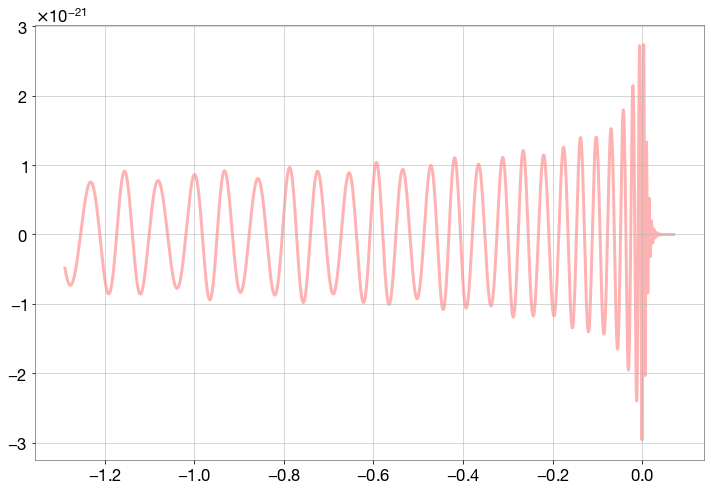

In [30]:
# plot the nr data in phys. units
plt.figure(figsize = (12, 8))
plt.plot(times_eob_new, h_phys_v2.real, "r", alpha=0.3, lw=3, label=r'NR real, 22 mode')
#plt.plot(times_eob_new, h_phys_v2.imag, "r", alpha=0.3, lw=3, label=r'NR imag')
#pylab.plot(times_eob_new, h_eob_phys_new.real, label="TEOBResumS")
pylab.plot(times_eob_new, hp_eob, label="TEOBResumS")
plt.xlabel(r'$t/M$')
plt.ylabel(r'$r \, h_+$')
plt.title(r'inclination = '+str(inclination/np.pi))
plt.legend(loc='upper left')